In [719]:
import numpy as np

In [720]:
data = np.load('mnist.npz')

In [721]:
# np.reshape
x_train_raw = data['x_train']
y_train_raw = data['y_train']
x_test_raw = data['x_test']
y_test_raw = data['y_test']
from sklearn.decomposition import PCA
# print("X_DATAPOINTS_raw = \n", x_train_raw.shape)
x_train_raw_2 = x_train_raw.reshape((x_train_raw.shape[0], -1))
x_test_raw_2 = x_test_raw.reshape((x_test_raw.shape[0], -1))
# print("x_train_raw_2 = \n", x_train_raw_2.shape)

x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(x_train_raw_2)):
    if (y_train_raw[i] == 0):
        x_train.append(x_train_raw_2[i])
        y_train.append(-1)
    if (y_train_raw[i] == 1):
        x_train.append(x_train_raw_2[i])
        y_train.append(1)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

for i in range(len(x_test_raw_2)):
    if (y_test_raw[i] == 0):
        x_test.append(x_test_raw_2[i])
        y_test.append(-1)
    if (y_test_raw[i] == 1):
        x_test.append(x_test_raw_2[i])
        y_test.append(1)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_test.shape, y_test.shape)

(12665, 784) (12665,)
(2115, 784) (2115,)


In [722]:
# split into train and val
indices_pos_1 = np.where(y_train == 1)[0]
indices_neg_1 = np.where(y_train == -1)[0]
# print(len(indices_pos_1), len(indices_neg_1))

np.random.seed(42)
np.random.shuffle(indices_pos_1)
np.random.shuffle(indices_neg_1)

val_pos_1 = indices_pos_1[:1000]
train_pos_1 = indices_pos_1[1000:]
val_neg_1 = indices_neg_1[:1000]
train_neg_1 = indices_neg_1[1000:]

trainX = np.concatenate((x_train[train_pos_1], x_train[train_neg_1]), axis=0)
trainY = np.concatenate((y_train[train_pos_1], y_train[train_neg_1]), axis=0)
valX = np.concatenate((x_train[val_pos_1], x_train[val_neg_1]), axis=0)
valY = np.concatenate((y_train[val_pos_1], y_train[val_neg_1]), axis=0)

train_indices = np.arange(trainX.shape[0])
val_indices = np.arange(valX.shape[0])
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

trainX = trainX[train_indices]
trainY = trainY[train_indices]
valX = valX[val_indices]
valY = valY[val_indices]

# print(trainX.shape, valX.shape)

# for i in range(len(valY)):
#     print(valY[i])

In [723]:
# obtain pca from train
pca = PCA(n_components=5)
X = pca.fit_transform(trainX)
print(X.shape)

# X is the final x_train. use X
Y = trainY
# Y is the final y_train. use Y
print(Y.shape)

X_VAL = pca.transform(valX)
Y_VAL = valY
print(X_VAL.shape)
print(Y_VAL.shape)


TEST_X = pca.transform(x_test)
TEST_Y = y_test

(10665, 5)
(10665,)
(2000, 5)
(2000,)


### 1.

In [724]:
def PredPerCut(x_data, y_data, dimensionIndex, split):
    left_pos_1 = 0
    left_neg_1 = 0
    right_pos_1 = 0
    right_neg_1 = 0
    for i in range(len(x_data)):
        if (x_data[i][dimensionIndex] < split):
            if (y_data[i] == 1): left_pos_1 += 1
            elif (y_data[i] == -1): left_neg_1 += 1
        if (x_data[i][dimensionIndex] >= split):
            if (y_data[i] == 1): right_pos_1 += 1
            elif (y_data[i] == -1): right_neg_1 += 1

    epsilon = 1e-15
    left_prediction = (left_pos_1 - left_neg_1) / (left_pos_1 + left_neg_1 + epsilon)
    right_prediction = (right_pos_1 - right_neg_1) / (right_pos_1 + right_neg_1 + epsilon)

    learning_rate = 0.01
    left_prediction = learning_rate * left_prediction
    right_prediction = learning_rate * right_prediction

    left_SSR = 0
    right_SSR = 0
    for i in range(len(x_data)):
        if (x_data[i][dimensionIndex] < split):
            left_SSR += ((y_data[i] - left_prediction) ** 2)
        elif (x_data[i][dimensionIndex] >= split):
            right_SSR += ((y_data[i] - right_prediction) ** 2)
    total_SSR = left_SSR + right_SSR
    
    # print(left_prediction)
    # print(right_prediction)
    # print(left_SSR)
    # print(right_SSR)
    # print(total_SSR)

    return total_SSR, left_prediction, right_prediction


In [725]:
# PredPerCut(X, Y, 0, 100)

### 2.

In [726]:
# sort and unique
# pick random points

def Split(x_train, y_train, numberOfDimensions):
    SortedDimensionsColumnsMatrix = []
    AllSplitsMatrix = []
    RandomIndicesMatrix = []
    RandomSplitsMatrix = []

    # Change this to change the number of splits being considered for each dimension of a tree
    numberOfSplitsToCompare = 50

    for i in range(numberOfDimensions):
        currentDimensionColumn = x_train[:, i]
        paired = list(zip(currentDimensionColumn, y_train))
        pairedUniqueSorted = sorted(set(paired), key=lambda x: x[0])
        currentDimensionColumn, correspondingLabel = zip(*pairedUniqueSorted)
        SortedDimensionsColumnsMatrix.append(currentDimensionColumn)

        # print(currentDimensionColumn)

        currentSplitArray = []
        for j in range(len(currentDimensionColumn)-1):
            currentSplitArray.append((currentDimensionColumn[j] + currentDimensionColumn[j+1])/2)
        currentSplitArray = np.array(currentSplitArray)
        AllSplitsMatrix.append(currentSplitArray)
        currentRandomIndices = np.random.randint(len(currentDimensionColumn)-1, size=numberOfSplitsToCompare)
        RandomIndicesMatrix.append(currentRandomIndices)

        currentRandomSplits = currentSplitArray[currentRandomIndices]
        RandomSplitsMatrix.append(currentRandomSplits)

    SortedDimensionsColumnsMatrix = np.array(SortedDimensionsColumnsMatrix)
    AllSplitsMatrix = np.array(AllSplitsMatrix) 
    RandomIndicesMatrix = np.array(RandomIndicesMatrix)
    RandomSplitsMatrix = np.array(RandomSplitsMatrix)

    # print(DimensionsColumnsMatrix.shape)
    # print(AllSplitsMatrix.shape)
    # print(RandomIndicesMatrix)
    # print(RandomSplitsMatrix)

    return SortedDimensionsColumnsMatrix, AllSplitsMatrix, RandomIndicesMatrix, RandomSplitsMatrix

In [727]:
# SortedDimensionsColumnsMatrix, AllSplitsMatrix, RandomIndicesMatrix, RandomSplitsMatrix = Split(X, Y, 5)
# print(SortedDimensionsColumnsMatrix.shape)
# print(AllSplitsMatrix.shape)
# print(RandomIndicesMatrix.shape)
# print(RandomSplitsMatrix.shape)

### 3.

In [728]:
def FindingMinSSR(RandomSplitsMatrix, x_data, y_data):
    LeftAndRightPredictionMatrix = []
    SSR_Matrix = []
    minSSR = float('inf')
    minSSR_SplitValue = None
    minSSR_DimensionIndex = None
    minSSR_J = None
    for i in range(len(RandomSplitsMatrix)):
        currentSSR_Array = []
        currentPredictionArray = []
        for j in range(len(RandomSplitsMatrix[i])):
            curr_SSR, left_prediction, right_prediction = PredPerCut(x_data, y_data, i, RandomSplitsMatrix[i][j])
            currentSSR_Array.append(curr_SSR)
            currentPredictionArray.append((left_prediction, right_prediction))
            if (curr_SSR < minSSR):
                minSSR = curr_SSR
                minSSR_SplitValue = RandomSplitsMatrix[i][j]
                minSSR_DimensionIndex = i
                minSSR_J = j
        SSR_Matrix.append(currentSSR_Array)
        LeftAndRightPredictionMatrix.append(currentPredictionArray)

    SSR_Matrix = np.array(SSR_Matrix)
    LeftAndRightPredictionMatrix = np.array(LeftAndRightPredictionMatrix)
    # print(SSR_Matrix.shape)
    # print(SSR_Matrix)
    # print(LeftAndRightPredictionMatrix.shape)
    return minSSR, minSSR_SplitValue, minSSR_DimensionIndex, minSSR_J, LeftAndRightPredictionMatrix
            

In [729]:
# FindingMinSSR(RandomSplitsMatrix, X, Y)

### 4.

In [730]:
def UpdatingLabels(x_data, y_data, SplitValue, DimInd, J, PredMat):
    for i in range(len(x_data)):

        if (x_data[i][DimInd] < SplitValue):
            pred = PredMat[DimInd][J][0]
        elif (x_data[i][DimInd] >= SplitValue):
            pred = PredMat[DimInd][J][1]
        
        # if (y_data[i] - pred >= 0):
        #     y_data[i] = 1
        # elif (y_data[i] - pred < 0):
        #     y_data[i] = -1

        y_data[i] -= pred
        
    return y_data 

In [731]:
Y_SOMETHING = Y.copy()

In [732]:
def MSEonVal(X_VAL, Y_VAL, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix, Y_SMTH):
    predictions = np.zeros(len(X_VAL))
    # for i in range(len(X_VAL)):
    #     if X_VAL[i][minLossDimensionIndex] < minLossSplitValue:
    #         pred = LeftAndRightPredictionMatrix[minLossDimensionIndex][minLossJ][0]
    #     else:
    #         pred = LeftAndRightPredictionMatrix[minLossDimensionIndex][minLossJ][1]
    #     predictions[i] = pred
    for i in range(len(X_VAL)):
        predictions[i] = Y_SMTH[i]
    squared_errors = (predictions - Y_VAL) ** 2
    mse = np.mean(squared_errors)
    
    return mse

In [733]:
# change to change depth
# RESIDUE_ARRAY = []
NumberOfStumps = 150
# val_accuracies = []
best_mse = 1000000
best_tree = None
val_mse = []
for i in range(NumberOfStumps):
    print(f"{i+1} stump")
    a, b, c, SPLITS_MATRIX = Split(X, Y_SOMETHING, 5)
    MIN_SSR, MIN_SSR_SPLITVALUE, MIN_SSR_DIMIND, MIN_SSR_J, LEFT_RIGHT_PREDS = FindingMinSSR(SPLITS_MATRIX, X, Y_SOMETHING)
    # val_acc = AccuracyOnVal(X_VAL, Y_VAL, MIN_SSR_SPLITVALUE, MIN_SSR_DIMIND, MIN_SSR_J, LEFT_RIGHT_PREDS)
    # print(val_acc)
    # val_accuracies.append(val_acc)
    CURRENT_MSE = MSEonVal(X_VAL, Y_VAL, MIN_SSR_SPLITVALUE, MIN_SSR_DIMIND, MIN_SSR_J, LEFT_RIGHT_PREDS, Y_SOMETHING)
    val_mse.append(CURRENT_MSE)
    print(CURRENT_MSE)

    if (best_mse > CURRENT_MSE):
        best_mse = CURRENT_MSE
        best_tree = (MIN_SSR_SPLITVALUE, MIN_SSR_DIMIND, MIN_SSR_J, LEFT_RIGHT_PREDS)

    Y_SOMETHING = UpdatingLabels(X, Y_SOMETHING, MIN_SSR_SPLITVALUE, MIN_SSR_DIMIND, MIN_SSR_J, LEFT_RIGHT_PREDS)

1 stump


2.03
2 stump
1.004
3 stump
1.0015
4 stump
1.0
5 stump
1.0
6 stump
1.0
7 stump
1.0
8 stump
1.0
9 stump
1.0
10 stump
1.0
11 stump
1.0
12 stump
1.0
13 stump
1.0
14 stump
1.0
15 stump
1.0
16 stump
1.0
17 stump
1.0
18 stump
1.0
19 stump
1.0
20 stump
1.0
21 stump
1.0
22 stump
1.0
23 stump
1.0
24 stump
1.0
25 stump
1.0
26 stump
1.0
27 stump
1.0
28 stump
1.0
29 stump
1.0
30 stump
1.0
31 stump
1.0
32 stump
1.0
33 stump
1.0
34 stump
1.0
35 stump
1.0
36 stump
1.0
37 stump
1.0
38 stump
1.0
39 stump
1.0
40 stump
1.0
41 stump
1.0
42 stump
1.0
43 stump
1.0
44 stump
1.0
45 stump
1.0
46 stump
1.0
47 stump
1.0
48 stump
1.0
49 stump
1.0
50 stump
1.0
51 stump
1.0
52 stump
1.0
53 stump
1.0
54 stump
1.0
55 stump
1.0
56 stump
1.0
57 stump
1.0
58 stump
1.0
59 stump
1.0
60 stump
1.0
61 stump
1.0
62 stump
1.0
63 stump
1.0
64 stump
1.0
65 stump
1.0
66 stump
1.0
67 stump
1.0
68 stump
1.0
69 stump
1.0
70 stump
1.0
71 stump
1.0
72 stump
1.0
73 stump
1.0
74 stump
1.0
75 stump
1.0
76 stump
1.0
77 stump
1.0
78 stump
1

In [735]:
if best_tree:
    minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix = best_tree
    TestAccuracy = MSEonVal(TEST_X, TEST_Y, minLossSplitValue, minLossDimensionIndex, minLossJ, LeftAndRightPredictionMatrix, Y_SOMETHING)
    print(f"Test MSE: {TestAccuracy}")
    # print(best_tree)
else:
    print("No tree was found.")

Test MSE: 1.0


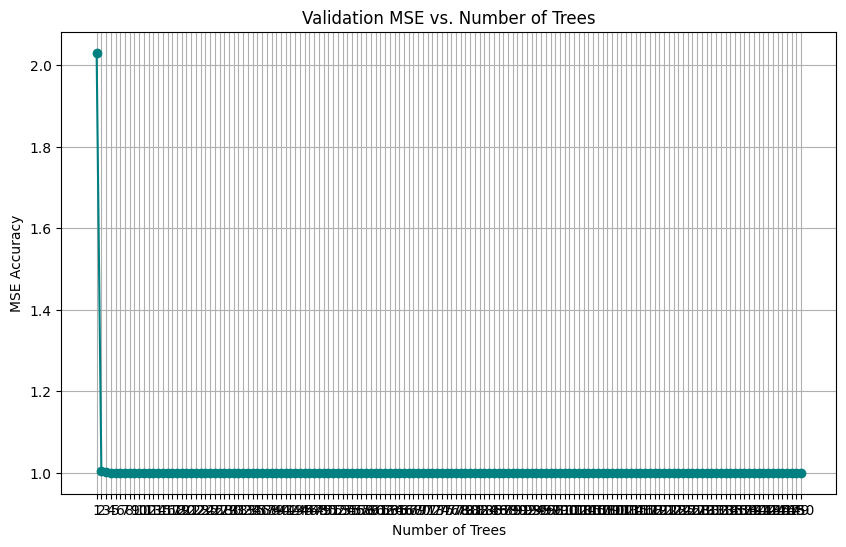

In [736]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', linestyle='-', color='blue')
plt.plot(range(1, len(val_mse)+1), val_mse, marker='o', linestyle='-', color='teal')
plt.title('Validation MSE vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('MSE Accuracy')
plt.grid(True)
plt.xticks(range(1, len(val_mse) + 1))
plt.show()
